In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Create directories
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("logs", exist_ok=True)
os.makedirs("plots", exist_ok=True)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
from torcheeg.datasets import DEAPDataset
from torcheeg import transforms
from torcheeg.datasets.constants import DEAP_CHANNEL_LOCATION_DICT

freq_bands = {
    "delta": (1, 4),
    "theta": (4, 8),
    "alpha": (8, 14),
    "beta": (14, 30),
    "gamma": (31, 50),
}

dataset1 = DEAPDataset(root_path=f'E:\FYP\DEAP_dataset\zip_files\data_preprocessed_python',
                    #   io_path=f'E:\FYP\Finalise Fyp\EEg-based-Emotion-Recognition\FYP_2\Hamza\.torcheeg\datasets_1747080987554_hVeOh',
                      offline_transform=transforms.Compose([
                             transforms.BandDifferentialEntropy(band_dict=freq_bands),  # Apply DE feature extraction
                             transforms.ToGrid(DEAP_CHANNEL_LOCATION_DICT)
                      ]),
                      online_transform=transforms.Compose([
                          transforms.To2d(),
                          transforms.ToTensor()
                      ]),
                      label_transform=transforms.Compose([
                          transforms.Select(['valence', 'arousal']),
                          transforms.Binary(5.0),
                          transforms.BinariesToCategory()
                      ]),
                      num_worker=4)
print(dataset1[0])
# EEG signal (torch.Tensor[1, 32, 128]),
# coresponding baseline signal (torch.Tensor[1, 32, 128]),
# label (int)

<>:13: SyntaxWarning: invalid escape sequence '\F'
<>:13: SyntaxWarning: invalid escape sequence '\F'
C:\Users\hamza\AppData\Local\Temp\ipykernel_9912\2029949000.py:13: SyntaxWarning: invalid escape sequence '\F'
  dataset1 = DEAPDataset(root_path=f'E:\FYP\DEAP_dataset\zip_files\data_preprocessed_python',
[2025-05-13 05:12:19] INFO (torcheeg/MainThread) 🔍 | Processing EEG data. Processed EEG data has been cached to .torcheeg\datasets_1747095139230_BudtW.
[2025-05-13 05:12:19] INFO (torcheeg/MainThread) ⏳ | Monitoring the detailed processing of a record for debugging. The processing of other records will only be reported in percentage to keep it clean.
[PROCESS]: 100%|██████████| 32/32 [1:15:40<00:00, 141.88s/it]
[2025-05-13 06:38:33] INFO (torcheeg/MainThread) ✅ | All processed EEG data has been cached to .torcheeg\datasets_1747095139230_BudtW.
[2025-05-13 06:38:33] INFO (torcheeg/MainThread) 😊 | Please set io_path to .torcheeg\datasets_1747095139230_BudtW for the next run, to directly

(tensor([[[[0.0000, 0.0000, 0.0000, 1.1133, 0.0000, 1.3244, 0.0000, 0.0000,
           0.0000],
          [0.0000, 0.0000, 0.0000, 1.0742, 0.0000, 1.5007, 0.0000, 0.0000,
           0.0000],
          [1.6778, 0.0000, 1.1781, 0.0000, 1.3846, 0.0000, 1.4698, 0.0000,
           0.7357],
          [0.0000, 0.6457, 0.0000, 1.1392, 0.0000, 0.9948, 0.0000, 0.5490,
           0.0000],
          [1.2121, 0.0000, 0.0125, 0.0000, 0.5365, 0.0000, 0.8897, 0.0000,
           0.5243],
          [0.0000, 0.5054, 0.0000, 0.6462, 0.0000, 0.4988, 0.0000, 0.5445,
           0.0000],
          [1.5552, 0.0000, 1.0938, 0.0000, 1.3668, 0.0000, 0.7541, 0.0000,
           1.5460],
          [0.0000, 0.0000, 0.0000, 1.4797, 0.0000, 1.2325, 0.0000, 0.0000,
           0.0000],
          [0.0000, 0.0000, 0.0000, 1.6763, 1.0572, 1.0256, 0.0000, 0.0000,
           0.0000]],

         [[0.0000, 0.0000, 0.0000, 3.0094, 0.0000, 3.7032, 0.0000, 0.0000,
           0.0000],
          [0.0000, 0.0000, 0.0000, 3.2409, 0.00

Applying t-SNE...
Applying t-SNE on sampled data...


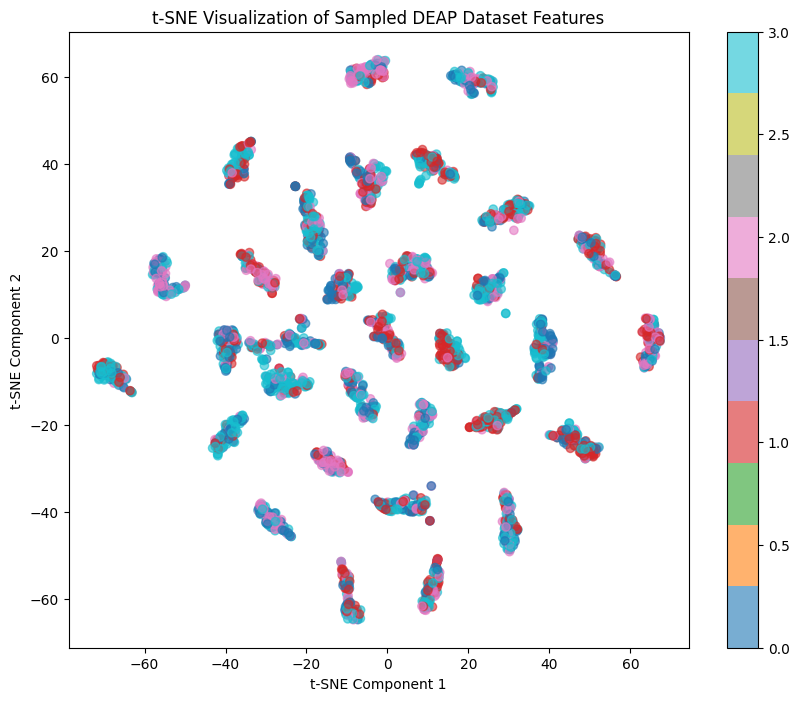

t-SNE visualization completed and saved to plots/tsne_visualization.png


In [6]:
# Add this to a new cell
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataLoader
batch_size = 64
dataloader = DataLoader(dataset1, batch_size=batch_size, shuffle=False)

# Collect features and labels
all_features = []
all_labels = []

print("Collecting features...")
with torch.no_grad():
    for batch_data in dataloader:
        eeg_signals, labels = batch_data
        # Reshape EEG signals to 2D (batch_size, channels * time_points)
        features = eeg_signals.view(eeg_signals.size(0), -1).cpu().numpy()
        all_features.append(features)
        all_labels.append(labels.cpu().numpy())

# Concatenate all batches
X = np.concatenate(all_features, axis=0)
y = np.concatenate(all_labels, axis=0)

print("Applying t-SNE...")
# Apply t-SNE
sample_size = 3000  # Or any number small enough to process quickly
indices = np.random.choice(len(X), sample_size, replace=False)
X_sample = X[indices]
y_sample = y[indices]

print("Applying t-SNE on sampled data...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne_sampled = tsne.fit_transform(X_sample)

# Visualization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne_sampled[:, 0], X_tsne_sampled[:, 1], c=y_sample, cmap='tab10', alpha=0.6)
plt.colorbar(scatter)
plt.title('t-SNE Visualization of Sampled DEAP Dataset Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.show()

print("t-SNE visualization completed and saved to plots/tsne_visualization.png")

In [7]:
data, label = dataset1[0]
print(data.shape)  # Should output: torch.Size([5, 9, 9])
print("Label:", label)


torch.Size([1, 5, 9, 9])
Label: 3


In [8]:
from torcheeg.datasets import DEAPDataset
from torcheeg import transforms
from torcheeg.datasets.constants import DEAP_CHANNEL_LOCATION_DICT

freq_bands = {
    "delta": (1, 4),
    "theta": (4, 8),
    "alpha": (8, 14),
    "beta": (14, 30),
    "gamma": (31, 50),
}

dataset1 = DEAPDataset(root_path=f'E:\FYP\DEAP_dataset\zip_files\data_preprocessed_python',
                    #   io_path=f'E:\FYP\Finalise Fyp\EEg-based-Emotion-Recognition\FYP_2\Hamza\.torcheeg\datasets_1747080987554_hVeOh',
                      offline_transform=transforms.Compose([
                             transforms.BandDifferentialEntropy(band_dict=freq_bands),  # Apply DE feature extraction
                      ]),
                      online_transform=transforms.Compose([
                          transforms.To2d(),
                          transforms.ToTensor()
                      ]),
                      label_transform=transforms.Compose([
                          transforms.Select(['valence', 'arousal']),
                          transforms.Binary(5.0),
                          transforms.BinariesToCategory()
                      ]),
                      num_worker=4)
print(dataset1[0])

<>:13: SyntaxWarning: invalid escape sequence '\F'
<>:13: SyntaxWarning: invalid escape sequence '\F'
C:\Users\hamza\AppData\Local\Temp\ipykernel_9912\2548468654.py:13: SyntaxWarning: invalid escape sequence '\F'
  dataset1 = DEAPDataset(root_path=f'E:\FYP\DEAP_dataset\zip_files\data_preprocessed_python',
[2025-05-13 06:39:23] INFO (torcheeg/MainThread) 🔍 | Processing EEG data. Processed EEG data has been cached to .torcheeg\datasets_1747100363968_wpFQ9.
[2025-05-13 06:39:23] INFO (torcheeg/MainThread) ⏳ | Monitoring the detailed processing of a record for debugging. The processing of other records will only be reported in percentage to keep it clean.
[PROCESS]: 100%|██████████| 32/32 [1:09:49<00:00, 130.91s/it]
[2025-05-13 07:57:43] INFO (torcheeg/MainThread) ✅ | All processed EEG data has been cached to .torcheeg\datasets_1747100363968_wpFQ9.
[2025-05-13 07:57:43] INFO (torcheeg/MainThread) 😊 | Please set io_path to .torcheeg\datasets_1747100363968_wpFQ9 for the next run, to directly

(tensor([[[1.1133, 3.0094, 3.4046, 3.0341, 1.6964],
         [1.0742, 3.2409, 3.3717, 3.1913, 1.5171],
         [1.1781, 3.4088, 3.1853, 3.2634, 1.9229],
         [1.6778, 2.6700, 3.3696, 3.1086, 1.7142],
         [0.6457, 2.2498, 2.9879, 2.5813, 1.1083],
         [1.1392, 2.2641, 2.7772, 2.7511, 1.0465],
         [0.0125, 2.1866, 3.2820, 2.8930, 1.3125],
         [1.2121, 3.1930, 3.3882, 3.4827, 2.5031],
         [0.5054, 2.7580, 3.6947, 2.9956, 1.5674],
         [0.6462, 2.7226, 3.4068, 2.5674, 1.2629],
         [1.0938, 3.4452, 3.9285, 3.1678, 1.8972],
         [1.5552, 3.2019, 3.9790, 3.4432, 2.4233],
         [1.4797, 3.4187, 4.0361, 3.1311, 1.9660],
         [1.6763, 3.3519, 3.8791, 3.1933, 2.2270],
         [1.0572, 3.1224, 3.7096, 2.9091, 1.7720],
         [1.3668, 3.0972, 3.4053, 2.5028, 1.1896],
         [1.3244, 3.7032, 3.5050, 3.4798, 1.8252],
         [1.5007, 3.3375, 3.5419, 3.3965, 1.5551],
         [1.3846, 3.5990, 3.4498, 3.0084, 1.2822],
         [1.4698, 3.9276, 3.34

Applying t-SNE...
Applying t-SNE on sampled data...


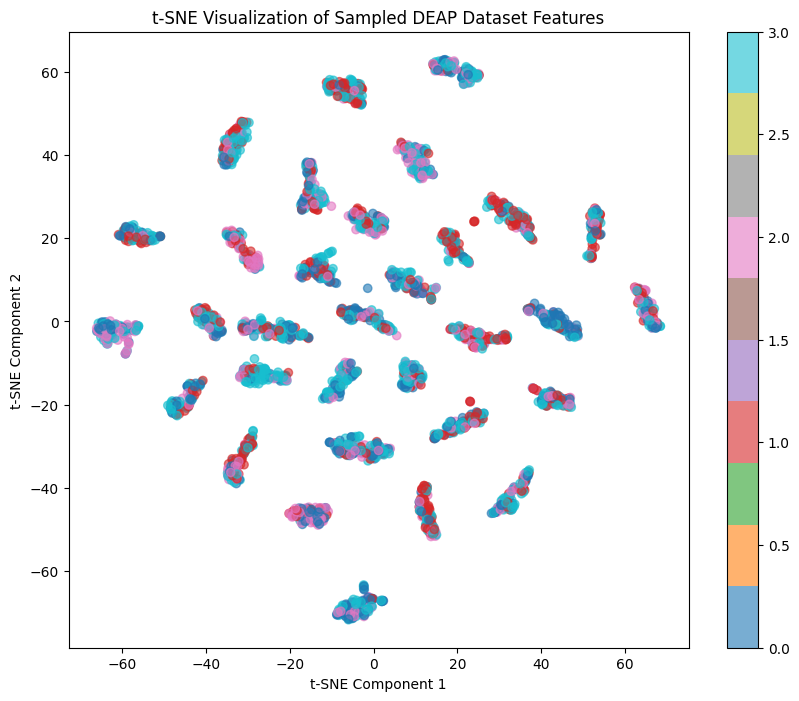

t-SNE visualization completed and saved to plots/tsne_visualization.png


In [9]:
# Add this to a new cell
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataLoader
batch_size = 64
dataloader = DataLoader(dataset1, batch_size=batch_size, shuffle=False)

# Collect features and labels
all_features = []
all_labels = []

print("Collecting features...")
with torch.no_grad():
    for batch_data in dataloader:
        eeg_signals, labels = batch_data
        # Reshape EEG signals to 2D (batch_size, channels * time_points)
        features = eeg_signals.view(eeg_signals.size(0), -1).cpu().numpy()
        all_features.append(features)
        all_labels.append(labels.cpu().numpy())

# Concatenate all batches
X = np.concatenate(all_features, axis=0)
y = np.concatenate(all_labels, axis=0)

print("Applying t-SNE...")
# Apply t-SNE
sample_size = 3000  # Or any number small enough to process quickly
indices = np.random.choice(len(X), sample_size, replace=False)
X_sample = X[indices]
y_sample = y[indices]

print("Applying t-SNE on sampled data...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne_sampled = tsne.fit_transform(X_sample)

# Visualization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne_sampled[:, 0], X_tsne_sampled[:, 1], c=y_sample, cmap='tab10', alpha=0.6)
plt.colorbar(scatter)
plt.title('t-SNE Visualization of Sampled DEAP Dataset Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.show()

print("t-SNE visualization completed and saved to plots/tsne_visualization.png")

In [10]:
data, label = dataset1[0]
print(data.shape)  # Should output: torch.Size([5, 9, 9])
print("Label:", label)


torch.Size([1, 32, 5])
Label: 3
